### Import libraries

In [1]:
import sys
import os
import gc
import numpy as np
import pandas as pd 
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [3]:
from util import *
%load_ext autoreload
%autoreload 2

In [4]:
set_gpu_limit(6)

### Split none onehot encoded data into train and test for categorical embedding

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_merged.csv")
features, y = data.drop("price",axis=1), data.price
X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.1,random_state=2020)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size=0.11,random_state=2020)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99186 entries, 0 to 99185
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   model          99186 non-null  object
 1   price          99186 non-null  int64 
 2   transmission   99186 non-null  object
 3   fuelType       99186 non-null  object
 4   binned_year    99186 non-null  int64 
 5   mil_cat        99186 non-null  int64 
 6   binned_mpg     99186 non-null  int64 
 7   engine_binned  99186 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


### We will embed columns model, transmission, and fuelType

--- 

### Garbage collect

In [7]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Setting up some constants

In [8]:
EMBED_COLS = ["model","transmission","fuelType"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 1e-3
numeric_size = [64,32]
model_size = [1024,512,256]
DROPOUT= [0.2,0.2]
METRICS = ["MAPE","MAE"]

In [9]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

### train, dev, and test data for NN

* model embed model input 
* transmission embed model input
* fuelType embed model input 
* numeric input data 

In [12]:
train_input,dev_input,test_input = cate_embed_process(X_train,X_dev,X_test,EMBED_COLS)

In [ ]:
base_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr)

In [ ]:
base_embed_model.summary()

In [ ]:
# history = base_embed_model.fit(train_input,y_train, epochs=MAX_EPOCH,shuffle=True,
#                          verbose = 1, validation_data=(dev_input,y_dev),
#                          callbacks=[earlystop])

In [ ]:
# base_embed_model.save("cate_embed_base_model.h5")

In [ ]:
base_embed_model = tfk.models.load_model("cate_embed_base_model.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

In [ ]:
# plot_metrics(history,"loss")

In [ ]:
# plot_metrics(history,"MAPE")

### Let's check model results 

In [ ]:
regression_metrics(base_embed_model,train_input,y_train,test_input,y_test,256)

In [ ]:
plot_pred_price(base_embed_model,test_input,y_test,batch_size=BATCH_SIZE)

In [ ]:
price_table = price_diff(base_embed_model,X_test,y_test,256, 1, test_input)

In [ ]:
price_table.sort_values("price_diff_abs",ascending=False).head(20)

### Similar to other models, cars that are old with high mileage tend to be over predicted by the model 

### Let's try a bigger model and see if it helps and increase embed size with slower learning rate 

In [ ]:
EMBED_COLS = ["model","transmission","fuelType"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [ ]:
bigger_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr,1.5)

In [ ]:
bigger_embed_model.summary()

In [ ]:
history = bigger_embed_model.fit(train_input,y_train, epochs=MAX_EPOCH,shuffle=True,
                         verbose = 1, validation_data=(dev_input,y_dev),
                         callbacks=[earlystop])

In [ ]:
plot_metrics(history,"loss")

In [ ]:
plot_metrics(history,"MAPE")

In [ ]:
bigger_embed_model.save("bigger_embed.h5")

In [9]:
bigger_embed_model = tfk.models.load_model("bigger_embed.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

In [13]:
regression_metrics(bigger_embed_model,train_input,y_train,test_input,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.944789,2317.732568,559.699650
test,0.937352,2414.391473,300.850962


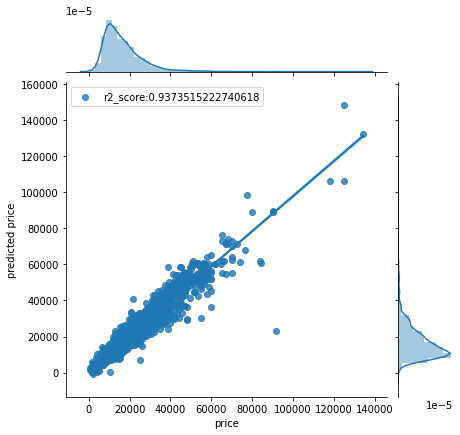

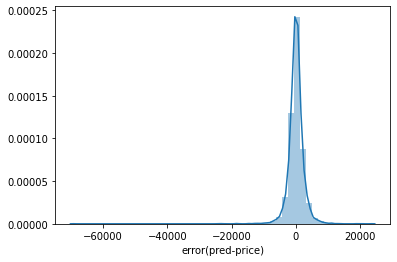

In [14]:
plot_pred_price(bigger_embed_model,test_input,y_test,batch_size=BATCH_SIZE)

In [15]:
price_diff(bigger_embed_model,X_test,y_test,256, 1, test_input).sort_values("price_diff_abs",ascending=False).head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
39978,A Class,Manual,Petrol,1,5,1,0,-300.850962,300.850962
40171,A Class,Automatic,Petrol,1,4,2,0,-230.342041,230.342041
12301,Golf,Manual,Petrol,2,4,2,0,-163.496094,163.496094
20056,Beetle,Manual,Petrol,1,4,2,0,-153.933049,153.933049
2450,Yaris,Automatic,Petrol,0,4,2,0,144.315531,144.315531
85142,Z4,Automatic,Petrol,1,4,1,1,-137.708641,137.708641
98626,TT,Manual,Petrol,1,5,1,0,-131.463641,131.463641
98752,A6,Automatic,Diesel,2,4,2,1,-120.849722,120.849722
88451,3 Series,Manual,Petrol,1,5,1,1,-98.611339,98.611339
52118,Zafira,Manual,Petrol,0,3,2,0,98.167737,98.167737


### Performance is slightly better but still have bin year and mil category issues. 

### Try embed other binned numerical features and see if the performance improves 

In [10]:
EMBED_COLS = ["model","transmission","fuelType","binned_year","mil_cat","binned_mpg","engine_binned"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [11]:
train_input_2,dev_input_2,test_input_2 = cate_embed_process(X_train,X_dev,X_test,EMBED_COLS)

In [12]:
all_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [13]:
all_embed_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [14]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",patience = 10, verbose =1, 
                                        restore_best_weights=True)


In [15]:
history = all_embed_model.fit(train_input_2,y_train, epochs=MAX_EPOCH,shuffle=True,
                         verbose = 1, validation_data=(dev_input_2,y_dev), callbacks=[earlystop])

Epoch 1/1000
2483/2483 [==============================] - 9s 4ms/step - loss: 32154936.0000 - MAPE: 21.4801 - MAE: 3194.2585 - val_loss: 20242540.0000 - val_MAPE: 17.3283 - val_MAE: 2593.6521
Epoch 2/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 13963310.0000 - MAPE: 15.7250 - MAE: 2321.7964 - val_loss: 15073333.0000 - val_MAPE: 13.9804 - val_MAE: 2165.6345
Epoch 3/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 11216617.0000 - MAPE: 13.5182 - MAE: 2054.1023 - val_loss: 13089735.0000 - val_MAPE: 12.6070 - val_MAE: 1992.6740
Epoch 4/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 10338782.0000 - MAPE: 12.7471 - MAE: 1978.8639 - val_loss: 12418125.0000 - val_MAPE: 12.2757 - val_MAE: 1963.0959
Epoch 5/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 9855404.0000 - MAPE: 12.3612 - MAE: 1941.9209 - val_loss: 12335305.0000 - val_MAPE: 11.6219 - val_MAE: 1949.5389
Epoch 6/1000
2483/2483 [=================

Epoch 44/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 6262406.0000 - MAPE: 10.5067 - MAE: 1641.9913 - val_loss: 8120980.5000 - val_MAPE: 10.9513 - val_MAE: 1679.3438
Epoch 45/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 6233777.0000 - MAPE: 10.4883 - MAE: 1637.8920 - val_loss: 8094569.5000 - val_MAPE: 10.0935 - val_MAE: 1624.1661
Epoch 46/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 6247075.0000 - MAPE: 10.5456 - MAE: 1644.8372 - val_loss: 8200347.0000 - val_MAPE: 10.3429 - val_MAE: 1654.1166
Epoch 47/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 6182806.0000 - MAPE: 10.5049 - MAE: 1639.1273 - val_loss: 8123573.5000 - val_MAPE: 10.0018 - val_MAE: 1635.2095
Epoch 48/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 6127366.0000 - MAPE: 10.4637 - MAE: 1633.8236 - val_loss: 8081204.5000 - val_MAPE: 10.1284 - val_MAE: 1640.9874
Epoch 49/1000
2483/2483 [====================

In [16]:
all_embed_model.save("All_embed.h5")

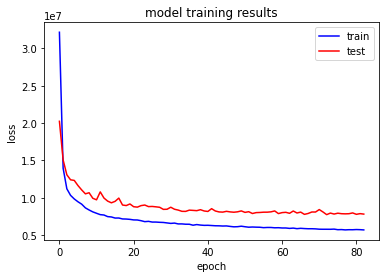

In [17]:
plot_metrics(history,"loss")

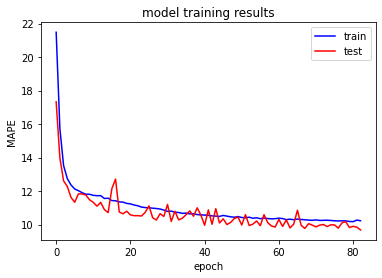

In [18]:
plot_metrics(history,"MAPE")

In [20]:
regression_metrics(all_embed_model,train_input_2,y_train,test_input_2,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.946415,2283.333531,502.005809
test,0.939695,2368.801219,274.129019


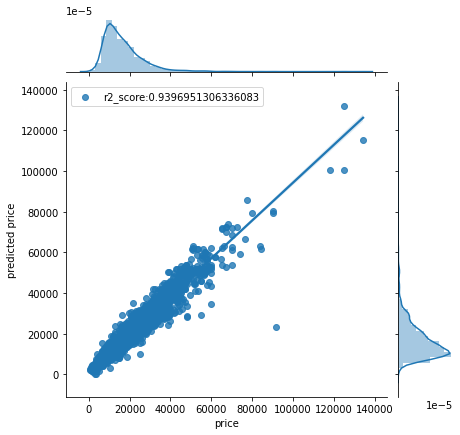

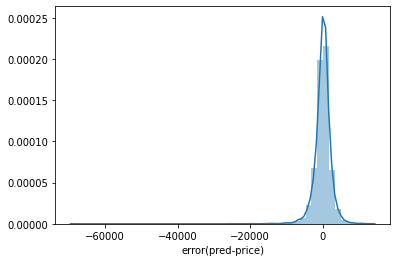

In [22]:
plot_pred_price(all_embed_model,test_input_2,y_test,batch_size=BATCH_SIZE)

In [24]:
price_diff(all_embed_model,X_test,y_test,256, 1, test_input_2).sort_values("price_diff_abs",ascending=False).head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
39978,A Class,Manual,Petrol,1,5,1,0,-274.129019,274.129019
71817,Focus,Manual,Petrol,1,5,1,0,-217.754051,217.754051
20056,Beetle,Manual,Petrol,1,4,2,0,-181.031006,181.031006
12301,Golf,Manual,Petrol,2,4,2,0,-152.842469,152.842469
40171,A Class,Automatic,Petrol,1,4,2,0,-148.753988,148.753988
98752,A6,Automatic,Diesel,2,4,2,1,-136.591413,136.591413
87143,5 Series,Manual,Petrol,0,4,1,0,-134.362297,134.362297
85142,Z4,Automatic,Petrol,1,4,1,1,-122.942038,122.942038
98626,TT,Manual,Petrol,1,5,1,0,-113.364945,113.364945
41293,Corsa,Manual,Diesel,2,4,4,0,-109.017778,109.017778


In [25]:
price_diff(all_embed_model,X_train,y_train,256, 1, train_input_2).sort_values("price_diff_abs",ascending=False).head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
20061,Beetle,Automatic,Petrol,1,0,1,0,-502.005809,502.005809
44539,Corsa,Manual,Petrol,1,4,3,0,-443.254666,443.254666
11984,Golf,Manual,Diesel,1,0,3,0,-430.748412,430.748412
47201,Astra,Manual,Petrol,1,5,2,0,-381.259657,381.259657
77582,Santa Fe,Manual,Petrol,1,4,1,1,-378.634806,378.634806
39711,C Class,Automatic,Diesel,1,2,1,1,-372.828275,372.828275
72016,Focus,Manual,Petrol,1,5,2,0,-362.945865,362.945865
71617,Fiesta,Manual,Petrol,1,4,2,0,-356.710384,356.710384
71819,Mondeo,Manual,Diesel,1,0,2,0,-347.145491,347.145491
39540,M Class,Semi-Auto,Petrol,1,5,1,1,-337.392603,337.392603


### Import orginal numerical data and treat year as categorical features and see if it slightly improves the model